In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, accuracy_score
from collections import defaultdict
from tqdm import tqdm
from transforms import *
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [2]:
pca = PCA()

training = pd.read_csv('first_round_training_data.csv')
testing = pd.read_csv('first_round_testing_data.csv')
features = ["Parameter5","Parameter6","Parameter7","Parameter8","Parameter9","Parameter10"]

training[features] = np.log(training[features].values)/np.log(10)
testing[features] = np.log(testing[features].values)/np.log(10)

code = {'Pass':1, 'Good':2, 'Excellent':3, 'Fail':0}
training['new_Quality'] = training['Quality_label'].apply(lambda x : code[x])

N = 5

skf = StratifiedKFold(n_splits=N, shuffle=False)
indices = []
for train_index, test_index in skf.split(training[features], training[['new_Quality']]):
    indices.append([train_index, test_index])
    
for group in range(100):
    name = 'group_%s'%group
    training[name] = 0
    kfold=KFold(n_splits=120, shuffle=True, random_state=group)
    split=kfold.split(training[features])
    i = 0
    for train_index, valid_index in split:
        training.iloc[valid_index, -1] = i
        i+=1

In [3]:
def normalize(values):
    values = values/0.02
    upper = np.ceil(values)
    lower = np.floor(values)
    for i in range(values.shape[0]):
        smallest_error = 10000
        for a in [upper[i, 0], lower[i, 0]]:
            for b in [upper[i, 1], lower[i, 1]]:
                for c in [upper[i, 2], lower[i, 2]]:
                    for d in [upper[i, 3], lower[i, 3]]:
                        if a+b+c+d == 50:
                            new_value = np.array([a, b, c, d])
                            new_error = np.mean(np.abs(new_value - values[i, :]))
                            if new_error < smallest_error:
                                smallest_error = new_error
                                best_option = new_value
        values[i, :] = best_option.copy()
    return values*0.02

def approx_score(probs, labels, groups):
    labels = labels.reshape(-1, 1)
    groups = groups.reshape(-1, 1)
    matrix = np.concatenate([probs, labels==0, labels==1, labels==2, labels==3, groups], axis=1)
    temp_frame = pd.DataFrame(data=matrix, 
                              columns=['prob1', 'prob2', 'prob3', 'prob4', 'label1', 'label2', 'label3', 'label4', 'group']
                             )
    temp_frame = temp_frame.groupby(['group']).mean()
    matrix = temp_frame.values
    mae1 = np.mean(np.abs(matrix[:, range(4)] - matrix[:, range(4, 8)]))
    score1 = 1/(1+10*mae1)
    rounded = normalize(matrix[:, range(4)])
    mae2 = np.mean(np.abs(rounded - matrix[:, range(4, 8)]))
    score2 = 1/(1+10*mae2)
    return matrix[:, range(4)], rounded, (score1, score2)

In [4]:
#train_all, test_all, new_features = get_all_WoE(training, testing, features)
#new_values = pca.fit_transform(pd.concat([train_all[new_features], test_all[new_features]]))
#train_all[new_features] = new_values[:6000, :].copy()
#test_all[new_features] = new_values[6000:, :].copy()
#new_features = new_features[:17]

In [5]:
train_all, test_all = training.copy(), testing.copy()
new_features = ["Parameter5","Parameter7","Parameter8","Parameter9","Parameter10"]

In [6]:
def train_test(iterations, depth, learning_rate, l2_norm):
    '''
    This function returns the trained model as well as some metrics with given training parameters
    
    The group assignment is random and done before calling this function so that the results are based on the same assignments
    
    outputs:
    ========
    offline_score1 : mean of scores from 100 random group assignment with probabilities predicted from trained model
    offline_score2 : mean of scores from 100 random group assignment with quantized probabilities
    matrix : 100 prediction values based on given group assignments
    rounded : 100 prediction values quantized to 0.02, based on given group assignments
    probs1 : out of fold probability prediction of the model for each sample
    probs2 : probability prediction for each sample in test data
    probs3 : probability prediction for each group in test data
    probs4 : quantized probability prediction for each group in test data
    '''
    model = CatBoostClassifier(iterations=iterations, 
                               depth=depth, 
                               learning_rate=learning_rate, 
                               silent=True, 
                               loss_function='MultiClass', 
                               l2_leaf_reg=l2_norm)
    probs1 = np.zeros((6000, 4))
    predictions = np.zeros(6000)
    train_neg_log_loss = []
    train_accuracy = []
    matrix = np.zeros((100, 120, 4))
    rounded = np.zeros((100, 120, 4))
    for j in range(N):
        train_index = indices[j][0]
        test_index = indices[j][1]
        counts = train_all.loc[train_index, 'new_Quality'].value_counts()
        counts = dict(zip(counts.index.values, np.max(counts.values)/counts.values))
        X_train = train_all.loc[train_index, new_features]
        y_train = train_all.loc[train_index, ['new_Quality']]
        weights = y_train['new_Quality'].apply(lambda x : counts[x])
        X_test = train_all.loc[test_index, new_features]
        #model.fit(X=X_train, y=y_train, sample_weight = weights)
        model.fit(X=X_train, y=y_train)
        probs1[test_index, :] = model.predict_proba(X_test)
        predictions[test_index] = model.predict(X_test).reshape(-1)
        train_accuracy.append(accuracy_score(y_train, model.predict(X_train)))
        train_neg_log_loss.append(-log_loss(y_train, model.predict_proba(X_train)))
    test_neg_log_loss = -log_loss(training['new_Quality'], probs1)
    test_accuracy = accuracy_score(training['new_Quality'], predictions)
    offline_score1 = []
    offline_score2 = []
    for j in range(100):
        matrix[j, :, :], rounded[j, :, :], scores = approx_score(probs1, training['new_Quality'].values, training['group_{}'.format(j)].values)
        offline_score1.append(scores[0])
        offline_score2.append(scores[1])
    
    print(np.mean(offline_score1), np.mean(offline_score2), test_neg_log_loss, test_accuracy)
    
    model.fit(X=train_all[new_features], y=train_all['new_Quality'], verbose = 100)
    probs2 = model.predict_proba(test_all[new_features])
    testing['Fail ratio'] = 0
    testing['Pass ratio'] = 0
    testing['Good ratio'] = 0
    testing['Excellent ratio'] = 0
    testing[['Fail ratio', 'Pass ratio', 'Good ratio', 'Excellent ratio']] = probs2
    submission = testing.groupby(['Group'], as_index=False).mean()
    submission = submission[['Group', 'Excellent ratio', 'Good ratio', 'Pass ratio', 'Fail ratio']]
    probs3 = submission[['Excellent ratio', 'Good ratio', 'Pass ratio', 'Fail ratio']].values
    probs4 = normalize(probs3)
    return offline_score1, offline_score2, matrix, rounded, probs1, probs2, probs3, probs4, model

In [7]:
score1_1, score2_1, matrix1, rounded1, prob1_1, prob2_1, prob3_1, prob4_1, model1 = train_test(500, 4, 0.1, 10)

0.6955763512630404 0.6965167733411398 -1.1136962616132138 0.515
0:	learn: 1.3460874	total: 10.6ms	remaining: 5.31s
100:	learn: 1.0872388	total: 865ms	remaining: 3.42s
200:	learn: 1.0635109	total: 1.73s	remaining: 2.57s
300:	learn: 1.0487187	total: 2.64s	remaining: 1.75s
400:	learn: 1.0400634	total: 3.61s	remaining: 890ms
499:	learn: 1.0334962	total: 4.5s	remaining: 0us


In [8]:
score1_2, score2_2, matrix2, rounded2, prob1_2, prob2_2, prob3_2, prob4_2, model2 = train_test(2250, 10, 0.01, 0)

0.6941037688385727 0.695210435330861 -1.1351637811897706 0.5125
0:	learn: 1.3810709	total: 113ms	remaining: 4m 13s
100:	learn: 1.1483319	total: 10s	remaining: 3m 33s
200:	learn: 1.0942578	total: 19s	remaining: 3m 13s
300:	learn: 1.0721848	total: 26.9s	remaining: 2m 53s
400:	learn: 1.0589994	total: 34.2s	remaining: 2m 37s
500:	learn: 1.0494554	total: 41.7s	remaining: 2m 25s
600:	learn: 1.0426779	total: 48s	remaining: 2m 11s
700:	learn: 1.0366205	total: 55.3s	remaining: 2m 2s
800:	learn: 1.0312240	total: 1m 2s	remaining: 1m 53s
900:	learn: 1.0265400	total: 1m 9s	remaining: 1m 44s
1000:	learn: 1.0222916	total: 1m 16s	remaining: 1m 34s
1100:	learn: 1.0184207	total: 1m 22s	remaining: 1m 26s
1200:	learn: 1.0129265	total: 1m 30s	remaining: 1m 18s
1300:	learn: 1.0074233	total: 1m 38s	remaining: 1m 11s
1400:	learn: 1.0020313	total: 1m 45s	remaining: 1m 4s
1500:	learn: 0.9968868	total: 1m 54s	remaining: 57s
1600:	learn: 0.9926627	total: 2m 2s	remaining: 49.7s
1700:	learn: 0.9887813	total: 2m 10s

In [9]:
train_maes = []
for i in range(100):
    train_maes.append(np.mean(np.abs(matrix1[i, :, :] - matrix2[i, :, :])))
    
rounded_maes = []
for i in range(100):
    rounded_maes.append(np.mean(np.abs(rounded1[i, :, :] - rounded2[i, :, :])))

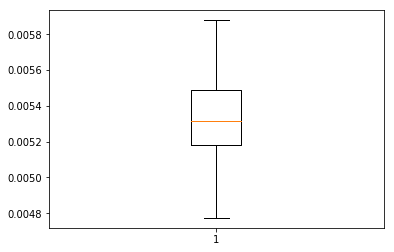

In [10]:
plt.boxplot(train_maes)
plt.show()

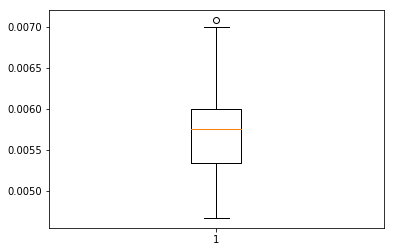

In [11]:
plt.boxplot(rounded_maes)
plt.show()

In [12]:
np.mean(np.abs(prob1_1 - prob1_2))

0.02738815241132719

In [13]:
np.mean(np.abs(prob2_1 - prob2_2))

0.022143302129449562

In [14]:
np.mean(np.abs(prob3_1 - prob3_2))

0.006698694997085729

In [15]:
np.mean(np.abs(prob4_1 - prob4_2))

0.007083333333333334

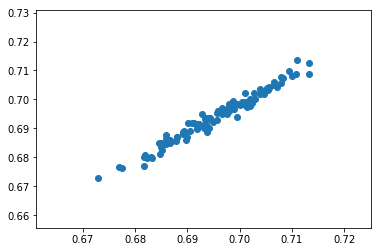

0.005711639356770326
0.0011767800454068195


In [16]:
plt.scatter(score1_1, score1_2)
plt.show()
print(np.max(np.abs(np.array(score1_1) - np.array(score1_2))))
print(np.max(np.abs( (1/np.array(score1_1)-1)/10 - (1/np.array(score1_2)-1)/10 )))

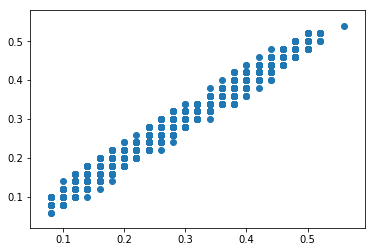

0.040000000000000036


In [17]:
plt.scatter(rounded1, rounded2)
plt.show()
print(np.max(np.abs(np.array(rounded1) - np.array(rounded2))))

In [18]:
def compare_score(prob1, prob2):
    '''
    This function takes in the out of fold probability predictions for each sample in training set from two models
    It generates a random group assignment and calculate the probability predictions, as well as quantized probability,
    for each group based on input, as well as the score
    Then it returns the MAE between predictions from two models, as well as their scores
    
    outputs:
    ========
    mae1 : MAE for probability predictions for groups of two models
    mae2 : MAE for quantized probability predictions for groups of two models
    score1 : score for first model
    score2 : score for second model
    '''
    groups = []
    for i in range(120):
        groups += [i]*50
    groups = np.random.choice(a=groups, replace=False, size=6000)
    labels = training['new_Quality'].values
    groups = groups.reshape(-1, 1)
    labels = labels.reshape(-1, 1)
    matrix1 = np.concatenate([prob1, labels==0, labels==1, labels==2, labels==3, groups], axis=1)
    temp_frame = pd.DataFrame(data=matrix1, 
                              columns=['prob1', 'prob2', 'prob3', 'prob4', 'label1', 'label2', 'label3', 'label4', 'group']
                             )
    temp_frame = temp_frame.groupby(['group']).mean()
    label_matrix = temp_frame[['label1', 'label2', 'label3', 'label4']].values
    matrix1 = temp_frame[['prob1', 'prob2', 'prob3', 'prob4']].values
    rounded1 = normalize(matrix1)
    score1 = np.mean(np.abs(matrix1 - label_matrix))
    matrix2 = np.concatenate([prob2, labels==0, labels==1, labels==2, labels==3, groups], axis=1)
    temp_frame = pd.DataFrame(data=matrix2, 
                              columns=['prob1', 'prob2', 'prob3', 'prob4', 'label1', 'label2', 'label3', 'label4', 'group']
                             )
    temp_frame = temp_frame.groupby(['group']).mean()
    matrix2 = temp_frame[['prob1', 'prob2', 'prob3', 'prob4']].values
    rounded2 = normalize(matrix2)
    score2 = np.mean(np.abs(matrix2 - label_matrix))
    mae1 = np.mean(np.abs(matrix1 - matrix2))
    mae2 = np.mean(np.abs(rounded1 - rounded2))
    return mae1, mae2, 1/(1+10*score1), 1/(1+10*score2)

In [19]:
#Seems that the difference is small
diff1 = []
diff2 = []
diff3 = []
for _ in range(1000):
    mae1, mae2, score1, score2 = compare_score(prob1_1, prob1_2)
    diff1.append(mae1)
    diff2.append(mae2)
    diff3.append(score1 - score2)

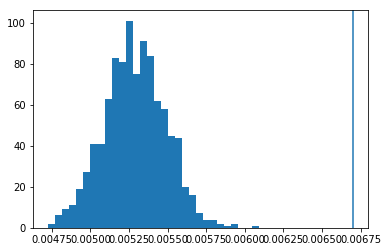

In [20]:
plt.hist(diff1, bins=30)
plt.axvline(x=np.mean(np.abs(prob3_1 - prob3_2)))
plt.show()

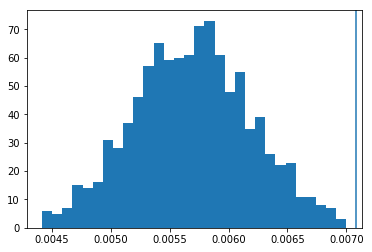

In [21]:
plt.hist(diff2, bins=30)
plt.axvline(x=np.mean(np.abs(prob4_1 - prob4_2)))
plt.show()

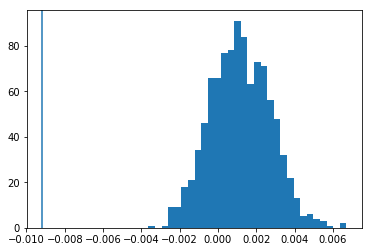

In [22]:
plt.hist(diff3, bins=30)
plt.axvline(x = 0.67895764000 - 0.68814070000)
plt.show()

In [23]:
def get_prediction(model, submit=False):
    probs = model.predict_proba(test_all[new_features])
    testing['Fail ratio'] = 0
    testing['Pass ratio'] = 0
    testing['Good ratio'] = 0
    testing['Excellent ratio'] = 0
    testing[['Fail ratio', 'Pass ratio', 'Good ratio', 'Excellent ratio']] = probs
    submission = testing.groupby(['Group'], as_index=False).mean()
    submission = submission[['Group', 'Excellent ratio', 'Good ratio', 'Pass ratio', 'Fail ratio']]
    if submit:
        submission.to_csv('submission.csv', index=False)
    matrix1 = submission[['Excellent ratio', 'Good ratio', 'Pass ratio', 'Fail ratio']].values.copy()
    matrix2 = normalize(matrix1)
    submission[['Excellent ratio', 'Good ratio', 'Pass ratio', 'Fail ratio']] = matrix2.copy()
    if submit:
        submission.to_csv('submission_rounded.csv', index=False)
    return matrix1, matrix2

In [24]:
_, _ = get_prediction(model1, submit = True)
#online score 0.67895764000, this seems to be unstable

In [25]:
_, _ = get_prediction(model2, submit = True)
#online score 0.68814070000, this seems to be stable?